In [1]:
%matplotlib inline


.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).


Simple graph classification task
--------------------------------
In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
different types of graphs and each class has the same number of graph samples.



(DGLGraph(num_nodes=18, num_edges=54,
         ndata_schemes={}
         edata_schemes={}), 0)


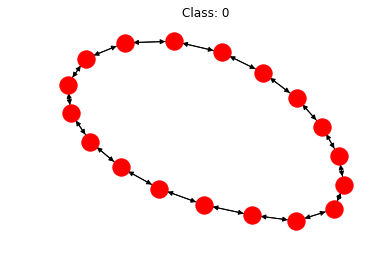

In [17]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
print(dataset[0])
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [18]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph. In the same way, 
a batch of tensors is still a tensor. This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
because DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph classifier
----------------
Graph classification proceeds as follows.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, perform message passing and graph convolution
for nodes to communicate with others. After message passing, compute a
tensor for graph representation from node (and edge) attributes. This step might 
be called readout or aggregation. Finally, the graph 
representations are fed into a classifier $g$ to predict the graph labels.

Graph convolution
-----------------
The graph convolution operation is basically the same as that for graph convolutional network (GCN). To learn more, 
see the GCN `tutorial <https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html>`_). The only difference is
that we replace $h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$ 
by
$h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$

The replacement of summation by average is to balance nodes with different
degrees. This gives a better performance for this experiment.

The self edges added in the dataset initialization allows you to
include the original node feature $h_{v}^{(l)}$ when taking the average.



In [19]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [20]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
print(trainset)

In [23]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=1, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        print(label)
        print(prediction)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

tensor([4])
tensor([[ 0.5410, -0.0054,  0.5461, -0.3615,  0.7102, -0.4029, -0.0480, -0.3077]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.2282, -0.1999,  0.0142, -0.8566,  2.7857, -0.5728, -0.4813, -0.5322]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[-0.1896,  0.9419, -0.4249, -1.2341,  3.2384, -0.7383, -0.8596, -0.8881]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[-0.2497,  1.0695, -0.5167, -0.7230,  1.4907, -0.4560, -0.6206, -0.4935]],
       grad_fn=<AddmmBackward>)
tensor([4])
tensor([[-0.0836,  2.0127, -0.8227, -1.1103,  1.5153, -0.7702, -0.9924, -0.9143]],
       grad_fn=<AddmmBackward>)
tensor([7])
tensor([[ 0.0992,  2.3436, -1.0354, -1.2591,  1.4179, -0.9560, -1.1649, -1.0954]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 0.1484,  1.8010, -0.9473, -1.0600,  0.9244, -0.8234, -0.9887, -0.6012]],
       grad_fn=<AddmmBackward>)
tensor([6])
tensor([[ 1.3969,  7.8414, -3.7705, -4.8682,  3.0728, -3.6785, -4.2658, -2.3830]],
       grad_fn=<

KeyboardInterrupt: 

The learning curve of a run is presented below.



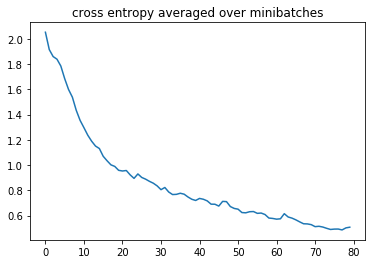

In [7]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [24]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

print(test_X)
print(test_Y)
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

[DGLGraph(num_nodes=19, num_edges=57,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=19, num_edges=57,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=10, num_edges=30,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=11, num_edges=33,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=10, num_edges=30,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=14, num_edges=42,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=14, num_edges=42,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=19, num_edges=57,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=16, num_edges=48,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=19, num_edges=57,
         ndata_schemes={}
         edata_schemes={}), DGLGraph(num_nodes=10, num_edges=28,
         ndata_schemes={}
         edata_schemes={})

The animation here plots the probability that a trained model predicts the correct graph type.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node and graph representations that a trained model learned,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after one and two
layers of graph convolution. The figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
you would not expect a perfect result. Node degrees are deterministic for
these node features. The graph features are improved when separated.

What's next?
------------
Graph classification with graph neural networks is still a new field.
It's waiting for people to bring more exciting discoveries. The work requires 
mapping different graphs to different embeddings, while preserving
their structural similarity in the embedding space. To learn more about it, see 
`How Powerful Are Graph Neural Networks? <https://arxiv.org/abs/1810.00826>`_ a research paper  
published for the International Conference on Learning Representations 2019.

For more examples about batched graph processing, see the following:

* Tutorials for `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* An example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_

